<a href="https://colab.research.google.com/github/Lexandrnew/Labs/blob/main/Copy_of_%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D1%8F%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Вы создадите классификатор логистической регрессии для распознавания кошек. Это задание расскажет, как это сделать с помощью нейронной сети, а также отточит вашу интуицию в отношении глубокого обучения.

**Инструкции:**
- Не используйте циклы (for / while) в своем коде, если только инструкции явно не требуют этого.

**Вы научитесь:**
- Создавать общую архитектуру алгоритма обучения, в том числе:
  - Инициализация параметров
  - Вычисление функции затрат и ее градиента
  - Использование алгоритма оптимизации (градиентный спуск)
- Собирать все эти три процедуры в основную функцию модели в правильном порядке.


## 1 - Пакеты ##

Во-первых, давайте запустим ячейку ниже, чтобы импортировать все пакеты, которые вам понадобятся во время этого назначения. 
- [numpy](https://numpy.org/) Это основной пакет для научных вычислений с Python.
- [h5py](http://www.h5py.org) пакет для взаимодействия с набором данных, который хранится в файле H5.
- [matplotlib](http://matplotlib.org)  знаменитая библиотека для построения графиков на Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) Используются здесь для проверки вашей модели с вашим собственным изображением в конце.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from scipy import ndimage
import os     
import urllib.request as url 

%matplotlib inline


def load_dataset():
    url.urlretrieve('https://github.com/andrew-veriga/Neural-Networks-and-Deep-Learning/raw/master/datasets/train_catvnoncat.h5', 'train_catvnoncat.h5')
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    url.urlretrieve('https://github.com/andrew-veriga/Neural-Networks-and-Deep-Learning/raw/master/datasets/test_catvnoncat.h5', 'test_catvnoncat.h5')
    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


## 2 - Описание набора задач ##
**Постановка задачи**: Вам предоставляется набор данных ('data.h5'), содержащий:
- учебный набор из m_train с метками "кошка" (y=1) или "не-кошка" (y=0)
- тестовый набор изображений m_test с метками  "кошка" или "не кошка"
- каждое изображение имеет размерность (num_px, num_px, 3), где последнее число - это  3 канала (RGB). Таким образом, каждое изображение квадратное: высота = num_px и ширина = num_px.

Вы построите простой алгоритм, который сможет правильно распознать изображение как кошку или не-кошку.

Давайте поближе познакомимся с набором данных. Загрузите данные, запустив следующий код.

In [ ]:
# Загрузка данных (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()


Мы добавили "_orig" в конце названий наборов данных изображений (тренировочного и тестового). После предварительной обработки, мы получим train_set_x и test_set_x (train_set_y и test_set_y не нуждаются в предварительной обработке).

Каждая строка вашего train_set_x_orig test_set_x_orig - это массив, представляющий изображение. Вы можете визуализировать пример, запустив следующий код. Попробуйте также запускать с другими значениями `index`, чтобы увидеть другие изображения.

y = [1], it's a 'cat' picture.


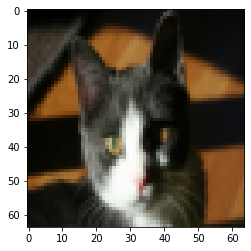

In [ ]:
# Пример изоражения
index = 19
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Многие программные ошибки в глубоком обучении связаны с несоответствием размерностей матриц и векторов. Если вы сможете разобраться с размерами матриц/векторов, вы сократите долгий путь по устранению многих ошибок. 

**Задание:** Найдите значения
    - m_train (количестов обучающих примеров)
    - m_test (количестов тестовых примеров)
    - num_px (= высота = ширина обучающего изображения)
Помните, что `train_set_x_orig` - это numpy-массив с размерностями (m_train, num_px, num_px, 3). Например, вы можете получить `m_train` вызвав `train_set_x_orig.shape[0]`.


In [ ]:
### НАЧАЛО ВАШЕГО КОДА ### (≈ 3 строки кода)
m_train = train_set_x_orig.shape[0]
m_test = train_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### КОНЕЦ ВАШЕГО КОДА ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


Number of training examples: m_train = 209
Number of testing examples: m_test = 209
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Ожидаемые значения для m_train, m_test and num_px**: \
```Python
m_train 209
m_test 50
num_px 64
```

Для удобства теперь следует заменить изображения с форматом `(num_px, num_px, 3)` на массивы numpy с размерностями (num_px * num_px * 3, 1). После этого наш обучающий (и тестовый) набор данных станет массивом numpy, в котором каждый столбец представляет собой вектор. Должно получиться m_train (соответственно m_test) столбцов.

**Упражнение:** Измените форму обучающих и тестовых наборов данных так, чтобы изображения размера (num_px, num_px, 3) вытянулись в отдельные векторы размерности (num _px\*num _px\*3, 1). \
\
Если вы хотите сгладить матрицу X формы (a,b,c,d) в матрицу X_flatten формы (b * c * d, a) используйте такой трюк:
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

```


In [ ]:
# Изменение формы тренировочных и тестовых примеров

### НАЧАЛО ВАШЕГО КОДА ### (≈ 2 строки кода)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### ОКОНЧАНИЕ ВАШЕГО КОДА ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))


train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Ожидаемый вывод**: 
```Python
train_set_x_flatten shape (12288, 209)
train_set_y shape (1, 209)
test_set_x_flatten shape (12288, 50)
test_set_y shape (1, 50)
sanity check after reshaping  [17 31 56 22 33]
```
Чтобы представлять цветные изображения, красный, зеленый и синий каналы (RGB) должны быть указаны для каждого пикселя, и поэтому значение пикселя на самом деле вектор из трех чисел, начиная от 0 до 255.

Во время обучения вашей модели модифицируете веса и добавите смещения к некоторым исходным входным данным, чтобы наблюдать активации нейронов. Затем вы используете градиенты для обучения модели. Чрезвычайно важно, чтобы все признаки находились в одинаковых диапазонах, чтобы наши градиенты не "взрывались". 

*О взрывающихся и исчезающих градиентах мы поговорим в последующих лекциях.*

Давайте стандартизируем наш набор данных.



In [ ]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

### **Что надо запомнить:**

Общие шаги подготовки нового набора данных:
- Выяснить размерности задачи (m_train, m_test, num_px, ...)
- Изменить наборы данных таким образом, чтобы каждый пример теперь был вектором размергости (num_px * num_px * 3, 1)
- «Стандартизировать» данные




##3 - Общая архитектура алгоритма обучения##

Пришло время разработать простой алгоритм, различающий  изображения кошек и  не-кошек.

Вы построите логистическую регрессию, используя логику нейронной сети. Следующая картинка объясняет, почему **Логистическая регрессия на самом деле очень простая нейронная сеть!**

<img src="https://upscfever.com/upsc-fever/en/data/deeplearning/images/LogReg_kiank.png" width=800>

**Математическое представление алгоритма**:

Для одного примера: $x^{(i)}$:
$$\begin{align}&z^{(i)} = w^T x^{(i)} + b \tag{1} \\
&\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2} \\
& \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}\end{align}$$

Затем потери вычисляются путем суммирования по всем примерам обучения:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

**Ключевые шаги**:

В этом упражнении вы выполните следующие шаги:
- Инициализировать параметры модели
- Обучить параметры модели, минимизируя затраты
- Использовать обученные параметры для прогнозирования (на тестовом наборе)
- Проанализировать результаты и сделать вывод


## 4 - Создание частей нашего алгоритма

Основные шаги построения нейронной сети:
1. Определить структуру модели (например, количество входных признаков)
2. Инициализировать параметры модели
3. Цикл:
  - Рассчитать текущие потери (проход вперёд)
  - Рассчитать текущий градиент (обратное распространение)
  - Обновить параметры (градиентный спуск)

Часто шаги 1-3 выполняются в одной функции, которую мы называем `model()`.



### 4.1 - Вспомогательные функции

**Упражнение:** реализуйте функцию `sigmoid()`. Как вы видели на рисунке выше, вам нужно вычислить $\sigma( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$, чтобы делать прогнозы. Используйте np.exp().


In [ ]:


def sigmoid(z):
    """
    Вычислить сигмоиду для z

    Arguments:
    z -- скаляр, или массив numpy

    Return:
    s -- sigmoid(z)
    """

    ### НАЧАЛО ВАШЕГО КОДА ### (≈ 1 строка кода)
    s = 1 / (1 + np.exp(-z))
    ### ОКОНЧАНИЕ ВАШЕГО КОДА ###

    return s

In [ ]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Ожидаемый вывод**: 
```
sigmoid([0, 2]) = [0.5        0.88079708]
```


###4.2 - Инициализация параметров

**Упражнение:** Вы должны инициализировать $w$ как вектор из нулей. Если вы не знаете, какую функцию использовать, посмотрите `np.zeros()` в документации библиотеки Numpy.

In [ ]:

def initialize_with_zeros(dim):
    """
    Эта функция создает вектор нулей формы (dim, 1) для w и инициализирует b равным 0.

    Аргумент:
    dim - размер вектора w, который нам нужен (или количество параметров в данном случае)

    Возврат:
    w - инициализированный вектор формы (dim, 1)
    b - инициализированный скаляр (смещение)
    """
    
    ### НАЧАЛО ВАШЕГО КОДА ### (≈ 1 строка кода)
    w = np.zeros((dim, 1))
    b = 0
    ### ОКОНЧАНИЕ ВАШЕГО КОДА ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b



In [ ]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))


w = [[0.]
 [0.]]
b = 0


**Ожидаемый вывод**: 
```
w = [[0.]
 [0.]]
b = 0
```

Для входных изображений `w` будет иметь форму (num_px $\times$ num_px $\times$ 3, 1).



### 4.3 - Распространение вперед и назад

Теперь, когда ваши параметры инициализированы, вы можете сделать шаги распространения "вперед" и "назад"  для обучения параметров.

**Упражнение:** Напишите функцию `propagate()`, которая вычисляет функцию затрат и ее градиент.

(Подсказки):

продвижение вперед:
- получаете $X$
- вычисляете $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- вычисляете функцию затрат $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

 
Вот две формулы, которые вы будете использовать:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [ ]:
def propagate(w, b, X, Y):
    """
    Реализуйте функцию стоимости и ее градиент для распространения, описанного выше.

    Arguments:
    w - веса, массив размерностью (num_px * num_px * 3, 1)
    b - смещение, скаляр
    X - данные размера (num_px * num_px * 3, количество примеров)
    Y - истинный вектор 'label' (содержащий 0, если не кошка, 1, если кошка) размера (1, количество примеров)

    Return:
    cost - стоимость отрицательного логарифма правдоподобия для логистической регрессии
    dw - градиент функции затрат по w, такой же размерности, как и w
    db - градиент потерь по b, такой же размерности, что и b

    Подсказки:
    - напишите свой код  для распространения шаг за шагом c с использованием np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (От X до получения затрат)
    ### НАЧАЛО ВАШЕГО КОДА ### (≈ 2 строки кода)
    A = sigmoid(np.dot(w.T, X) + b)                              # вычисляет активацию
    cost = -1 / m * np.sum(np.dot(Y, np.log(A).T) + np.dot((1 - Y), np.log(1 - A).T))   # вычисляет затраты
    ### ОКОНЧАНИЕ ВАШЕГО КОДА ###
    
    # BACKWARD PROPAGATION (поиск градиента)
    ### НАЧАЛО ВАШЕГО КОДА ### (≈ 2 строк кода)
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y)
    ### ОКОНЧАНИЕ ВАШЕГО КОДА ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost


In [ ]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))


dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553



**Ожидаемый вывод**:
```Python
dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553
```


### 4.4 - Оптимизация
- Вы инициализировали свои параметры.
- Вы можете вычислить функцию затрат и ее градиент.
- Теперь вам надо обновить параметры, используя градиентный спуск.

**Упражнение:** Напишите функцию оптимизации. Цель состоит в том, чтобы обучить $w$ и $b$, минимизируя функцию стоимости $J$. Для параметра $\theta$ правило обновления: $ \theta = \theta - \alpha \ d\theta$, где $\alpha$ - скорость обучения.

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Эта функция оптимизирует w и b, запуская алгоритм градиентного спуска
    Arguments:
    w -- веса, numpy-массив размера (num_px * num_px * 3, 1)
    b -- смещение, скаляр
    X -- данные формы (num_px * num_px * 3, количество примеров)
    Y -- вектор 'меток' (содержащий 0, если не кошка и 1, если кошка), формы (1, количество примеров)
    Num_iterations - количество итераций цикла оптимизации
    Learning_rate - скорость обучения правила обновления градиентного спуска
    Print_cost - True, чтобы печатать потери каждые 100 шагов

    Returns:
    Params - словарь, содержащий веса w и смещение b
    grads - словарь, содержащий градиенты весов и смещения относительно функции стоимости
    costs - список всех затрат, рассчитанных во время оптимизации, будет использоваться для построения кривой обучения.
        
    Советы:
    Вы должны записать два шага и итерировать их:
    1) Рассчитать затраты и градиент для текущих параметров. Используйте propagate().
    2) Обновить параметры с использованием правила градиентного спуска для w и b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Вычисление затрат и градиента (? 1-4 строк кода)
        ### НАЧАЛО ВАШЕГО КОДА ### 
        grads, cost = propagate(w, b, X, Y)
        ### ОКОНЧАНИЕ ВАШЕГО КОДА ###
        
        # Получение производных из grads
        dw = grads["dw"]
        db = grads["db"]
        
        # обновить веса и смещение (? 2 строки кода)
        ### НАЧАЛО ВАШЕГО КОДА ###
        w -= learning_rate * dw
        b -= learning_rate * db
        ### ОКОНЧАНИЕ ВАШЕГО КОДА ###
        
        # Записать затраты
        if i % 100 == 0:
            costs.append(cost)
        
        # Вывести затраты через каждых 100 обучающих примеров
        if print_cost and i % 100 == 0:
            print ("Затраты после итерации %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
params_, grads_, costs_ = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params_["w"]))
print ("b = " + str(params_["b"]))
print ("dw = " + str(grads_["dw"]))
print ("db = " + str(grads_["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


**Ожидаемый вывод**: 

``` Python
w = [[0.19033591] 
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652
```


**Упражнение:** Предыдущая функция выведет обученные w и b. Мы можем использовать w и b для прогнозирования меток набора данных X. Реализуйте функцию `predict()`. Расчет прогнозов состоит из двух этапов:
**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There is two steps to computing predictions:

1. Вычисление $A = \sigma(w^T X + b)$

2. Конвертирование $A$ в 0 (если активация <= 0,5) или 1 (если активация > 0,5), 
3. сохранение прогнозы в векторе `Y_prediction`. При желании вы можете использовать оператор if / else в цикле for (хотя есть также способ векторизовать это)


In [ ]:

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Вычислить вектор A, предсказывающий вероятность присутствия кошки на картинке.
    ### НАЧАЛО ВАШЕГО КОДА ### (? 1 строка кода)
    A = sigmoid(np.dot(w.T, X) + b)
    ### ОКОНЧАНИЕ ВАШЕГО КОДА ###
    
    for i in range(A.shape[1]):
        
        # Конвертировать вероятности A[0,i] в актуальные прогнозы Y[0,i]
        ### НАЧАЛО ВАШЕГО КОДА ### (? 4 строк кода)
            if A[0,i] <= 0.5 :
              Y_prediction[0,i] = 0
            else :
              Y_prediction[0,i] = 1  
        ### ОКОНЧАНИЕ ВАШЕГО КОДА ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction



In [ ]:
w_ = np.array([[0.1124579],[0.23106775]])
b_ = -0.3
X_ = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("прогнозы = " + str(predict(w_, b_, X_)))

прогнозы = [[1. 1. 0.]]


**Ожидаемый вывод**: 

`прогнозы:            [[ 1.  1.  0.]]`

**Что надо запомнить:**

Вы реализовали несколько функций, которые:
- Инициализировали (w, b)
- Итеративно оптимизировали затраты, обучив параметры (w, b):
  - рассчитали функцию затрат и ее градиент
  - произвели обновление параметров с помощью градиентного спуска
- Использовали изученные (w, b), чтобы предсказать метки для данного набора примеров


## 5 - Объединим все функции в модель ##

Теперь, собрав вместе все блоки (функции, реализованные в предыдущих частях), вы увидите всю структурированную модель.

**Exercise:** Implement the model function. Use the following notation:
**Упражнение.** Реализация модели. Используйте следующие обозначения:
- Y_prediction для ваших прогнозов на тестовом наборе;
- Y_prediction_train для ваших обучающего набора прогнозов;
- w, costs, grads для выводов функции optimize()


In [ ]:


def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- тренировочный набор, представленный массивом numpy формы (num_px * num_px * 3, m_train)
    Y_train -- обучающие метки, представленные массивом (вектором) numpy формы (1, m_train)
    X_test --  тестовый набор, представленный массивом numpy формы (num_px * num_px * 3, m_test)
    Y_test -- тестовые метки, представленные массивом (вектором) numpy формы (1, m_test)
    num_iterations -- гиперпараметр, представляющий количество итераций для оптимизации параметров
    learning_rate -- гиперпараметр "скорость обучения", используемый в функции оптимизации optimize()
    print_cost -- Установите в true, чтобы выводить cost каждые 100 итераций.
    
    Returns:
    d -- словарь, содержащий информацию о модели
    """
    
    ### НАЧАЛО ВАШЕГО КОДА ###

    # initialize parameters with zeros (~ 1 строка кода)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (~ 1 строка кода)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # получить параметры w and b из словаря "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # тестовые/обучающие наборы примеров (~ 2 строки кода)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### ОКОНЧАНИЕ ВАШЕГО КОДА ###

    # Вывести точность данных на обучающем и тестовом наборах
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d


Запустите следующую ячейку для тренировки вашей модели

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Затраты после итерации 0: 0.693147
Затраты после итерации 100: 0.584508
Затраты после итерации 200: 0.466949
Затраты после итерации 300: 0.376007
Затраты после итерации 400: 0.331463
Затраты после итерации 500: 0.303273
Затраты после итерации 600: 0.279880
Затраты после итерации 700: 0.260042
Затраты после итерации 800: 0.242941
Затраты после итерации 900: 0.228004
Затраты после итерации 1000: 0.214820
Затраты после итерации 1100: 0.203078
Затраты после итерации 1200: 0.192544
Затраты после итерации 1300: 0.183033
Затраты после итерации 1400: 0.174399
Затраты после итерации 1500: 0.166521
Затраты после итерации 1600: 0.159305
Затраты после итерации 1700: 0.152667
Затраты после итерации 1800: 0.146542
Затраты после итерации 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Ожидаемый вывод**: 
```
Потери после итерации 0: 0.693147
...
...
...
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %
```

**Комментарий**: точность обучения близка к 100%. Это хорошая проверка работоспособности: ваша модель работает и имеет достаточно высокую способность к совпадению с обучающими данными. Ошибка теста 68%. На самом деле это неплохо для такой простой модели, учитывая небольшой набор данных, который мы использовали, и то, что логистическая регрессия тут - простой линейный классификатор.


Используя приведенный ниже код (и изменив переменную index), вы можете просматривать прогнозы на изображениях тестового набора.


In [ ]:
classes[int(d["Y_prediction_test"][0,index])]

b'non-cat'

y = 1, you predicted that it is a "cat" picture.


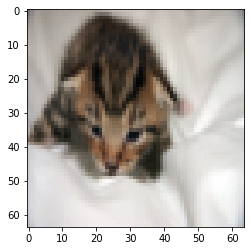

In [ ]:
# Пример изображения которая ошибочно классифицируется.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(test_set_y[0,index])].decode("utf-8") +  "\" picture.")



Давайте нарисуем функцию затрат и градиент

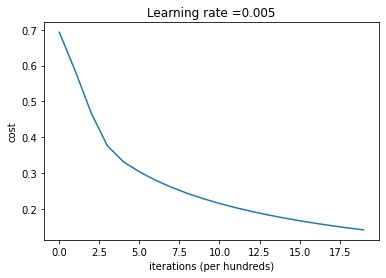

In [ ]:
# Кривая процесса обучения (изменение затрат по мере итерации)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Интерпертация**:
Вы можете видеть снижение потерь. Это показывает, что параметры обучаются. Однако тут видно, что вы можете лучше обучить модель на обучающей выборке. Попробуйте увеличить количество итераций в ячейке выше и перезапустите ячейки. Вы можете увидеть, что точность обучающего набора повышается, но точность набора тестов снижается. Это называется **overfitting**.


##6 - Дальнейший анализ (необязательное / упражнение)##

Поздравляем с созданием вашей первой модели классификации изображений. Давайте проанализируем его дальше и рассмотрим возможные варианты изменения скорости обучения $\alpha$.

#### Выбор скорости обучения ####

**Напоминание**:
Чтобы градиентный спуск работал, вы должны осмысленно выбирать скорость обучения. Скорость обучения $\alpha$ определяет, насколько быстро мы обновляем параметры. Если скорость обучения слишком велика, мы можем "перескочить" оптимальное значение. Точно так же, если она слишком мала, нам понадобится слишком много итераций, чтобы достичь хороших значений. Вот почему так важно использовать хорошо настроенную скорость обучения.

Давайте сравним кривую обучения нашей модели с несколькими вариантами скорости обучения. Запустите ячейку ниже. Это займет около 1 минуты. Попробуйте также  значения, отличные от тех трех чисел, которыми мы инициализировали переменную `learning_rates`, и посмотреть, что произойдет.

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()


**Интерпретация**: 
- Разные скорости обучения приводят к разным затратам и, следовательно, к разным результатам прогнозов.
- Если скорость обучения слишком велика (0,01), стоимость может колебаться вверх и вниз. Он может даже расходиться (хотя в этом примере использование 0,01 все равно в конечном итоге дает хорошее соотношение цены и качества).
- Более низкие затраты не означает лучшую модель. Вы должны проверить, нет ли оверфиттинга. Это случается, когда точность на этапе обучения намного выше, чем точность на этапе тестирования.
- При глубоком обучении мы обычно рекомендуем:
     - Выберите скорость обучения, которая лучше минимизирует функцию затрат.
     - При оверфиттинге используйте другие методы, чтобы уменьшить переобучение.

## 7 - Проверка с вашим собственным изображением (дополнительное упражнение) ##


Поздравляю с завершением этого задания. Вы можете использовать собственное изображение и увидеть результат своей модели. Для этого:\
     1. Нажмите «Файлы» на боковой панели этого ноутбука, затем нажмите "загрузить в хранилище".\
     2. Добавьте свое изображение в текущий каталог Jupyter Notebook.\
     3. Измените название изображения в следующем коде.\
     4. Запустите код и проверьте правильность алгоритма (1 = кошка, 0 = не кошка)!

In [ ]:
import imageio
from skimage.transform import resize
## НАЧАЛО ВАШЕГО КОДА ## 
my_image = "7_9c58af28.jpg"   # измените на имя ВАШЕГО файла изображения с кошкой, или без кошки
## ОКОНЧАНИЕ ВАШЕГО КОДА ##

# Мы предварительно обработаем изображение, чтобы соответствовать вашему алгоритму.
fname = "images/" + my_image
image = np.array(plt.imread(fname))
resized_image = resize(image, (num_px,num_px)).reshape((1, num_pxnum_px3)).T
my_predicted_image = predict(d["w"], d["b"], resized_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**Что нужно помнить из этого задания:**
1. Предварительная обработка набора данных важна.
2. Вы реализовали каждую функцию отдельно: initialize(), propagate(), optimize(). Затем вы построили model().
3. Настройка скорости обучения (которая является одним из т.н «гиперпараметров») может иметь большое значение для алгоритма. 

Наконец, если хотите, можете попробовать разные вещи в этом блокноте. - Играйте со скоростью обучения и количеством итераций
- Попробуйте разные методы инициализации и сравните результаты
- Протестируйте другие предварительные обработки (центрируйте данные или разделите каждую строку на ее стандартное отклонение)

Справочная литература:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c
